In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib import cm

In [60]:
data =pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv")

In [61]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831


In [62]:
data['price'] = (data['High']+ data['Low'])/2
data.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)#
data['Timestamp'] = pd.to_datetime(data['Timestamp'],unit='s')
data = data.set_index('Timestamp')
data = data.resample('1D').mean()
data = data.dropna()
data


,price
Timestamp,
2011-12-31,4.473750
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.211667
...,...
2020-12-27,27044.036733
2020-12-28,26963.621417
2020-12-29,26670.453208


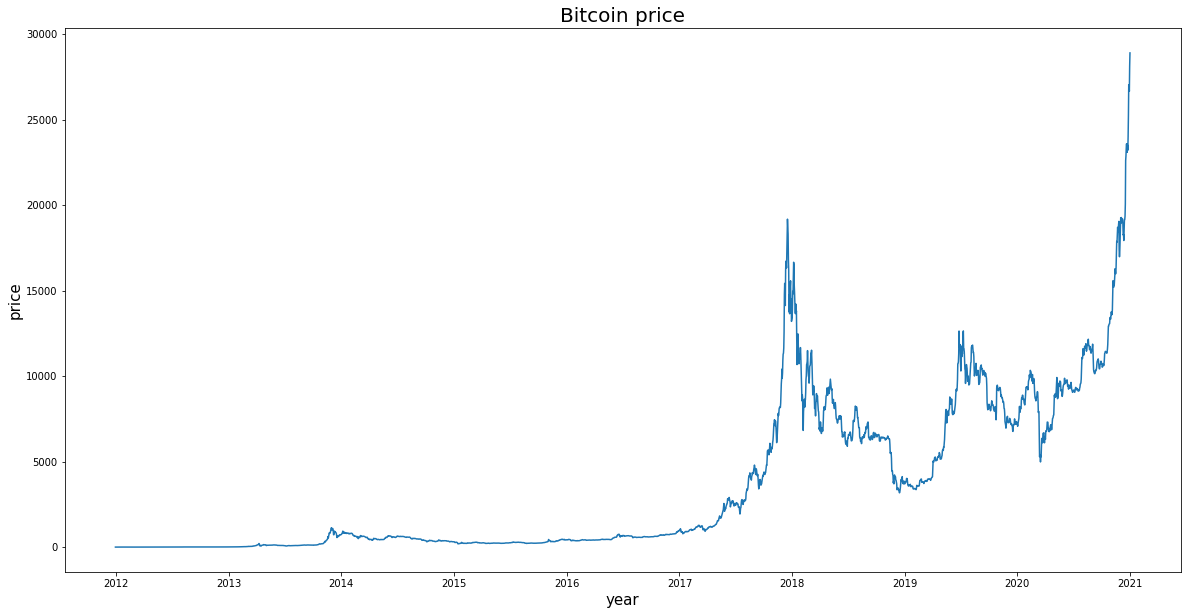

In [63]:
plt.figure(figsize=(20,10))
plt.plot(data)
plt.title('Bitcoin price',fontsize=20)
plt.xlabel('year',fontsize=15)
plt.ylabel('price',fontsize=15)
plt.show()

In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [65]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(data['price']).reshape(-1,1))
data['price'] = price

In [71]:
# change time-series format to the forecasting format
# in other world we use the price of the last few days for forecasting next days 
# D number of feature or number of days

In [72]:
X_l = []
y_l = []
N = len(data)
D = 20
for i in range(N-D-1):
    X_l.append(data.iloc[i:i+D])
    y_l.append(data.iloc[i+D])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)

(3265, 20, 1) (3265, 1)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)

In [74]:
print(len(X_test))
print(len(X_train))

653
2612


In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [76]:
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='SGD',loss='mean_squared_error')
    return model
model_bilstm = create_bilstm(256)

In [77]:
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='SGD',loss='mean_squared_error')
    return model
model_gru = create_gru(256)

In [78]:
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 20, 256)           198912    
                                                                 
 gru_5 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 593,921
Trainable params: 593,921
Non-trainable params: 0
_________________________________________________________________


In [79]:
model_bilstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 20, 512)          528384    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,103,809
Trainable params: 2,103,809
Non-trainable params: 0
_________________________________________________________________


In [80]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)


Epoch 1/100
131/131 [==============================] - 4s 11ms/step - loss: 0.0191 - val_loss: 0.0137
Epoch 2/100
131/131 [==============================] - 1s 7ms/step - loss: 0.0105 - val_loss: 0.0077
Epoch 3/100
131/131 [==============================] - 1s 7ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 4/100
131/131 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 5/100
131/131 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/100
131/131 [==============================] - 1s 7ms/step - loss: 8.5290e-04 - val_loss: 5.4682e-04
Epoch 7/100
131/131 [==============================] - 1s 7ms/step - loss: 4.9351e-04 - val_loss: 3.3434e-04
Epoch 8/100
131/131 [==============================] - 1s 7ms/step - loss: 3.7084e-04 - val_loss: 2.5245e-04
Epoch 9/100
131/131 [==============================] - 1s 6ms/step - loss: 3.2915e-04 - val_loss: 2.1779e-04
Epoch 10/100
131/131 [==============================] - 1s

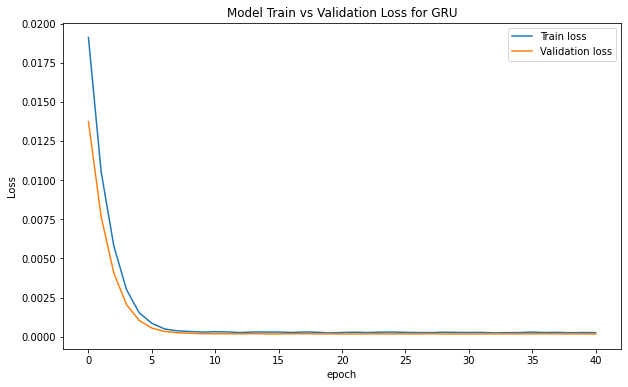

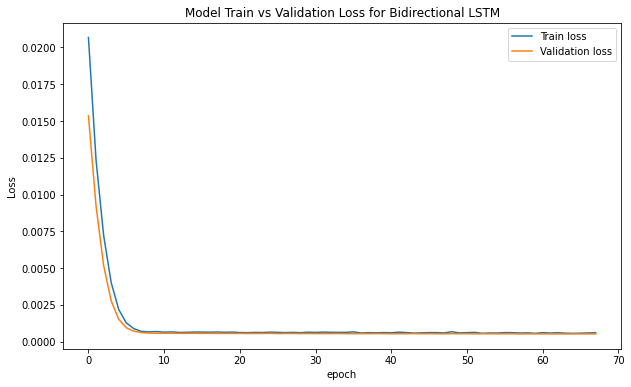

In [81]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

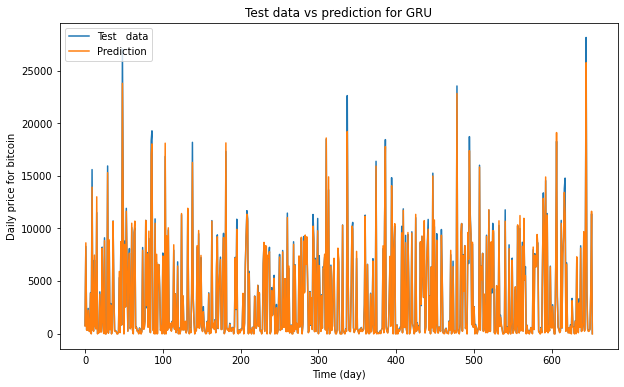

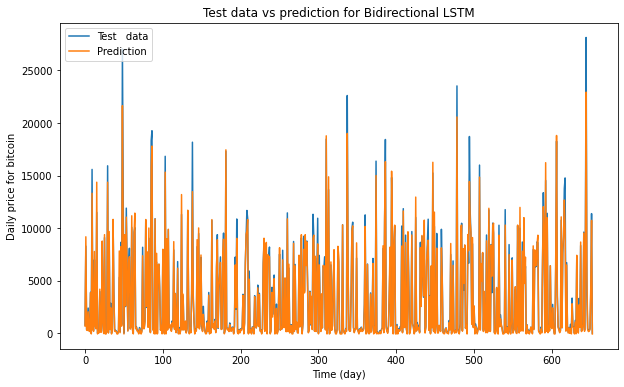

In [82]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction


def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily price for bitcoin')
 
plot_future(prediction_gru, 'GRU', scaler.inverse_transform(y_test))
plot_future(prediction_bilstm, 'Bidirectional LSTM', scaler.inverse_transform(y_test))

In [83]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 3250.7681
Root Mean Square Error: 5578.4416

Bidirectiona LSTM:
Mean Absolute Error: 3214.1348
Root Mean Square Error: 5486.7523



In [91]:
new_data = data.iloc[-80:]
# Scale the input
scaled_data = scaler.inverse_transform(new_data)
# scaled_data = new_data

# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_30= create_dataset(new_data,20)
print('X_30.shape: ', X_30.shape)

X_30.shape:  (60, 20, 1)


In [93]:
End = data.iloc[-80:]
# Scale the input
end_select = scaler.inverse_transform(End)

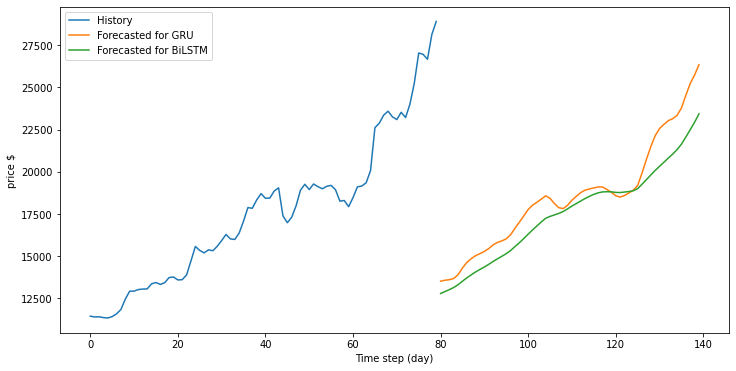

In [95]:
def prediction(model):
    prediction = model.predict(X_30)
    # print(prediction)
    prediction = scaler.inverse_transform(prediction)
    # print(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2):
    
    plt.figure(figsize=(12, 6))
    range_history = len(history)
    range_future = np.arange(80,140)
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2),
             label='Forecasted for BiLSTM')
      
    plt.legend(loc='upper left')
    plt.xlabel('Time step (day)')
    plt.ylabel('price $')
        
plot_multi_step(end_select, prediction_gru, prediction_bilstm)